In [2]:
import os
from os import path
from pydub import AudioSegment
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Flatten
def load_wav_16k_mono(filename):
    file_contents=tf.io.read_file(filename)
    wav,sample_rate=tf.audio.decode_wav(file_contents,desired_channels=1)
    wav=tf.squeeze(wav,axis=-1)
    sample_rate=tf.cast(sample_rate,dtype=tf.int64)
#     wav=tfio.audio.resample (wav,rate_in=sample_rate,rate_out=16000)
    return wav
# plt.plot(load_wav_16k_mono(r"C:\Users\Acer\Downloads\archive\gunshots\9 (8).wav"));
GUN=r'C:\Users\Acer\Downloads\gunshots'
OTHER=r"C:\Users\Acer\Downloads\others"
gun=tf.data.Dataset.list_files(GUN+'\*.wav')
other=tf.data.Dataset.list_files(OTHER+'\*.wav')

C:\Users\Acer\anaconda3\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [3]:
gun.as_numpy_iterator().next()
guns=tf.data.Dataset.zip((gun,tf.data.Dataset.from_tensor_slices(tf.ones(len(gun)))))
others=tf.data.Dataset.zip((other,tf.data.Dataset.from_tensor_slices(tf.zeros(len(other)))))
data=guns.concatenate(others)

In [3]:
data.shuffle(10000).as_numpy_iterator().next()

(b'C:\\Users\\Acer\\Downloads\\gunshots\\3 (78).wav', 1.0)

In [54]:
length=[]
for file in os.listdir(r'C:\Users\Acer\Downloads\gunshots'):
    tensor_wave=load_wav_16k_mono(os.path.join(r'C:\Users\Acer\Downloads\gunshots',file))
    length.append(len(tensor_wave))
for file in os.listdir(r'C:\Users\Acer\Downloads\others'):
    tensor_wave=load_wav_16k_mono(os.path.join(r'C:\Users\Acer\Downloads\others',file))
    length.append(len(tensor_wave))  

In [43]:
length

[144000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 192000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 144000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 88200,
 88200,
 88200,
 88200,
 96000,
 88200,
 88200,
 88200,
 88200,
 88200,
 88200,
 88200,
 88200,
 88200,
 88200,
 96000,
 88200,
 88200,
 88200,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 96000,
 9600

In [30]:
print(tf.math.reduce_mean(length))
print(tf.math.reduce_min(length))
print(tf.math.reduce_max(length))

tf.Tensor(148561, shape=(), dtype=int32)
tf.Tensor(44100, shape=(), dtype=int32)
tf.Tensor(15876000, shape=(), dtype=int32)


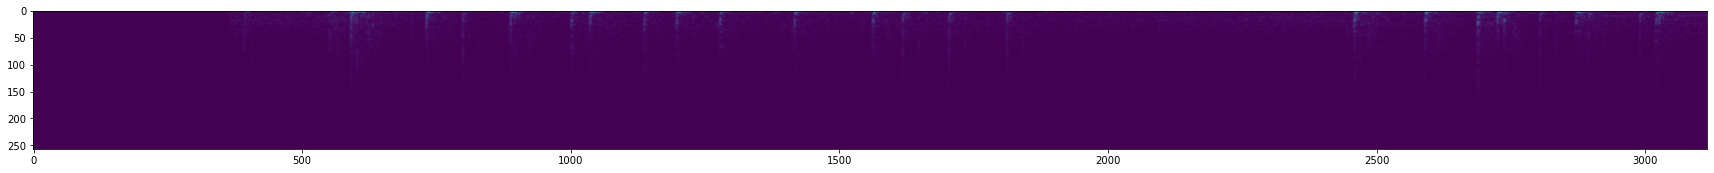

In [4]:
def preprocess(file_path,label):
    wav=load_wav_16k_mono(file_path)
    wav=wav[:100000]
    zero_padding=tf.zeros([100000]-tf.shape(wav),dtype=tf.float32)
    wav=tf.concat([zero_padding,wav],0)
    spectrogram=tf.signal.stft(wav,frame_length=320,frame_step=32)
    spectrogram=tf.abs(spectrogram)
    spectrogram=tf.expand_dims(spectrogram,axis=2)
    return spectrogram,label
filepath,label=guns.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram,label=preprocess(filepath,label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0]);

In [5]:
data=data.map(preprocess)

In [6]:
samples,label=data.as_numpy_iterator().next()
samples.shape

(3116, 257, 1)

In [7]:
model=Sequential() 
model.add(Conv2D(16,(3,3),activation='relu',input_shape=(3116, 257, 1)))
model.add(Conv2D(16,(3,3),activation='relu')) 
model.add(Flatten())
# model.add(Dense(128,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile('Adam',loss='BinaryCrossentropy',metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [8]:
data=data.cache()
data=data.shuffle(buffer_size=1000)
data=data.batch(16)
data=data.prefetch(8)

In [9]:
model.fit(data,epochs=10,steps_per_epoch=5)

Epoch 1/10
5/5 [==============================] - 115s 13s/step - loss: 0.1021 - recall: 1.0000 - precision: 1.0000
Epoch 2/10
5/5 [==============================] - 58s 12s/step - loss: 45.5692 - recall: 1.0000 - precision: 0.9875
Epoch 3/10
5/5 [==============================] - 52s 10s/step - loss: 0.6581 - recall: 1.0000 - precision: 0.9875
Epoch 4/10
5/5 [==============================] - 45s 9s/step - loss: 0.0000e+00 - recall: 1.0000 - precision: 1.0000
Epoch 5/10
5/5 [==============================] - 73s 14s/step - loss: 6.7812 - recall: 1.0000 - precision: 0.9875
Epoch 6/10
5/5 [==============================] - 64s 13s/step - loss: 0.0087 - recall: 1.0000 - precision: 0.9875
Epoch 7/10
5/5 [==============================] - 67s 13s/step - loss: 2.1687 - recall: 1.0000 - precision: 0.9875
Epoch 8/10
5/5 [==============================] - 71s 14s/step - loss: 1.4266e-31 - recall: 1.0000 - precision: 1.0000
Epoch 9/10
5/5 [==============================] - 81s 17s/step - loss: 

In [10]:
model.save(r'C:\Users\Acer\OneDrive\Desktop\hack36\Gunshotdetector.h5')

In [11]:
#if mp3 file then use this
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([100000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram
#if mp3 file mention its path
# filepath=r"C:\Users\Acer\Downloads\12-Gauge-Pump-Action-Shotgun-Far-Gunshot-A-www.fesliyanstudios.com.mp3"
# sound = AudioSegment.from_mp3(filepath)
# wavfile=filepath[:-3]+'wav'
# sound.export(wavfile, format="wav")
wav = load_wav_16k_mono(r"C:\Users\Acer\Downloads\screams\mixkit-screaming-people-at-mechanical-game-fair-349.wav")
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [ ]:
yhat = model.predict(audio_slices)
print(yhat)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [44]:
if sum(yhat)/len(yhat)>0.5:
    print("gunshot detected")
else:
    print("no gunshot")

gunshot detected
